# DEMO: Survey module functionalities

This notebook provides a demo of how to utilise the survey module.

In [2]:
import sys
sys.path.append('../../')

import numpy as np
import pandas as pd
import niimpy
from niimpy.survey import *
from niimpy.EDA import EDA_categorical, EDA_countplot

## Load data
We will load a mock survey data file.

In [3]:
# Load a mock dataframe
df = niimpy.read_csv('mock-survey.csv')
df.head()


,user,age,gender,Little interest or pleasure in doing things.,Feeling down; depressed or hopeless.,Feeling nervous; anxious or on edge.,Not being able to stop or control worrying.,In the last month; how often have you felt that you were unable to control the important things in your life?,In the last month; how often have you felt confident about your ability to handle your personal problems?,In the last month; how often have you felt that things were going your way?,In the last month; how often have you been able to control irritations in your life?,In the last month; how often have you felt that you were on top of things?,In the last month; how often have you been angered because of things that were outside of your control?,In the last month; how often have you felt difficulties were piling up so high that you could not overcome them?
0,1,20,Male,several-days,more-than-half-the-days,not-at-all,nearly-every-day,almost-never,sometimes,fairly-often,never,sometimes,very-often,fairly-often
1,2,32,Male,more-than-half-the-days,more-than-half-the-days,not-at-all,several-days,never,never,very-often,sometimes,never,fairly-often,never
2,3,15,Male,more-than-half-the-days,not-at-all,several-days,not-at-all,never,very-often,very-often,fairly-often,never,never,almost-never
3,4,35,Female,not-at-all,nearly-every-day,not-at-all,several-days,very-often,fairly-often,very-often,never,sometimes,never,fairly-often
4,5,23,Male,more-than-half-the-days,not-at-all,more-than-half-the-days,several-days,almost-never,very-often,almost-never,sometimes,sometimes,very-often,never


In [4]:
df.describe()

,user,age
count,1000.000000,1000.000000
mean,500.500000,26.911000
std,288.819436,4.992595
min,1.000000,12.000000
25%,250.750000,23.000000
50%,500.500000,27.000000
75%,750.250000,30.000000
max,1000.000000,43.000000


## Preprocessing 
The dataframe's columns are raw questions from a survey. Some questions belong to a specific category, so we will annotate them with ids. The id is constructed from a prefix (the questionnaire category: GAD, PHQ, PSQI etc.), followed by the question number (1,2,3). Similarly, we will also the answers to meaningful numerical values.

**Note:** It's important that the dataframe follows the below schema before passing into niimpy.

In [5]:
# Convert column name to id, based on provided mappers from niimpy
col_id = {**PHQ2_MAP, **PSQI_MAP, **PSS10_MAP, **PANAS_MAP, **GAD2_MAP}
selected_cols = [col for col in df.columns if col in col_id.keys()]

# Convert data frame to long format
m_df = pd.melt(df, id_vars=['user', 'age', 'gender'], value_vars=selected_cols, var_name='question', value_name='answer')

# Assign questions to codes 
m_df['id'] = m_df['question'].replace(col_id)
m_df.head()

,user,age,gender,question,answer,id
0,1,20,Male,Little interest or pleasure in doing things.,several-days,PHQ2_1
1,2,32,Male,Little interest or pleasure in doing things.,more-than-half-the-days,PHQ2_1
2,3,15,Male,Little interest or pleasure in doing things.,more-than-half-the-days,PHQ2_1
3,4,35,Female,Little interest or pleasure in doing things.,not-at-all,PHQ2_1
4,5,23,Male,Little interest or pleasure in doing things.,more-than-half-the-days,PHQ2_1


We can use a helper method to convert the answers into numerical value. The pre-defined mapper inside survey.py would be useful for this step.

In [6]:
# Transform raw answers to numerical values
m_df['answer'] = niimpy.survey.convert_to_numerical_answer(m_df, answer_col = 'answer',
                                question_id = 'id', id_map=ID_MAP_PREFIX, use_prefix=True)
m_df.head()

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2021-04-tf2/8ea88952/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,user,age,gender,question,answer,id
0,1,20,Male,Little interest or pleasure in doing things.,1,PHQ2_1
1,2,32,Male,Little interest or pleasure in doing things.,2,PHQ2_1
2,3,15,Male,Little interest or pleasure in doing things.,2,PHQ2_1
3,4,35,Female,Little interest or pleasure in doing things.,0,PHQ2_1
4,5,23,Male,Little interest or pleasure in doing things.,2,PHQ2_1


We can also produce a summary of the questionaire's score. This function can describe aggregated score over the whole population, or specific subgroups.

In [7]:
d = niimpy.survey.print_statistic(m_df)
pd.DataFrame(d)

,GAD2,PHQ2,PSS10
min,0.000000,0.0000,4.000000
max,6.000000,6.0000,27.000000
avg,3.042000,3.0520,14.006000
std,1.536423,1.5855,3.687759


In [8]:
d = niimpy.survey.print_statistic(m_df, group='gender')
pd.DataFrame(d)

GAD2                PHQ2                PSS10           
       Female      Male    Female      Male     Female       Male
min  0.000000  0.000000  0.000000  0.000000   4.000000   4.000000
max  6.000000  6.000000  6.000000  6.000000  27.000000  23.000000
avg  3.087576  2.998035  3.067210  3.037328  14.059063  13.954813
std  1.585157  1.488141  1.605337  1.567567   3.783230   3.596247

In [9]:
d = niimpy.survey.print_statistic(m_df, group='gender', prefix='PHQ')
pd.DataFrame(d)

## TODO: Add a method to categorize score into levels
## TODO: Extend to demographics info

PHQ          
       Female      Male
min  0.000000  0.000000
max  6.000000  6.000000
avg  3.067210  3.037328
std  1.605337  1.567567

## Visualization

We can now make some plots for the preprocessed data frame. First, we can display the summary for a specific question.

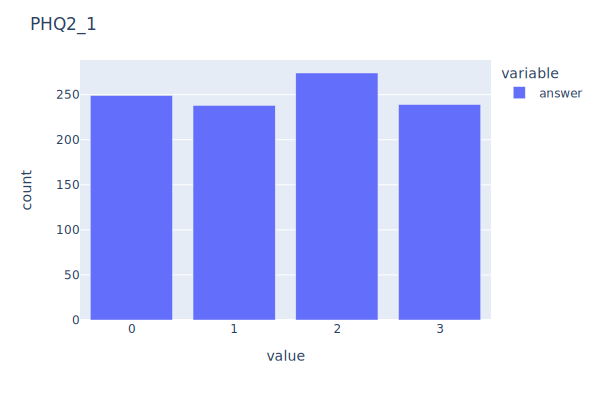

In [10]:
fig = niimpy.EDA.EDA_categorical.questionnaire_summary(m_df, question = 'PHQ2_1', column = 'answer', 
                                                       title='PHQ2_1', xlabel='value', ylabel='count', 
                                                       width=600, height=400)
fig.show('svg')

We can also display the summary for each subgroup.

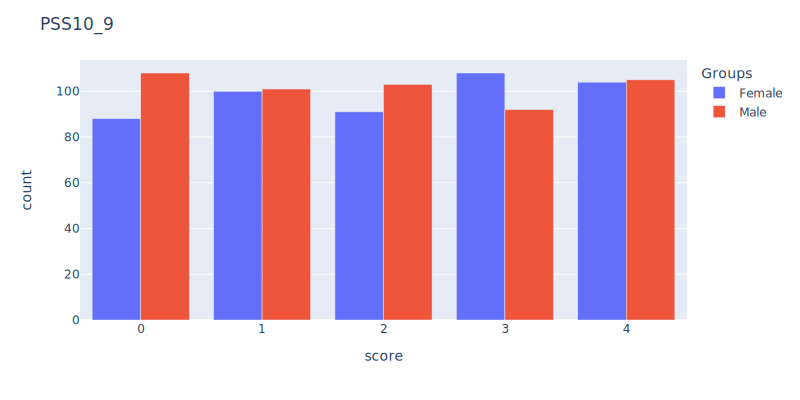

In [11]:
fig = niimpy.EDA.EDA_categorical.questionnaire_grouped_summary(m_df, question='PSS10_9', group='gender', 
                                                               title='PSS10_9',
                                                               xlabel='score', ylabel='count',
                                                               width=800, height=400)
fig.show('svg')

With some quick preprocessing, we can display the score distribution of each questionaire.

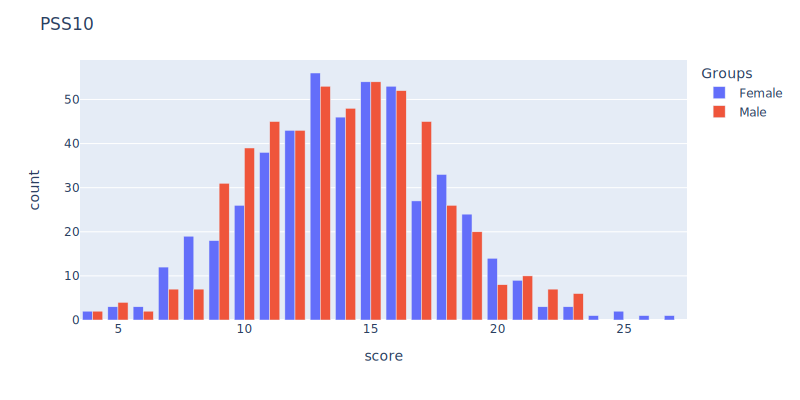

In [12]:
pss_sum_df = m_df[m_df['id'].str.startswith('PSS')] \
                            .groupby(['user', 'gender']) \
                            .agg({'answer':sum}) \
                            .reset_index()
pss_sum_df['id'] = 'PSS'
fig = niimpy.EDA.EDA_categorical.questionnaire_grouped_summary(pss_sum_df, question='PSS', group='gender', 
                                                               title='PSS10',
                                                               xlabel='score', ylabel='count',
                                                               width=800, height=400)
fig.show('svg')